In [423]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from meteostat import Point, Daily, units
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline


In [424]:
# Set time period
N = 75
end = datetime.now()
start = datetime(end.year - N, end.month, end.day)

# Create Point for NYC
nyc = Point(40.7789, -73.9692, 3.0)

# fetch data series
data = Daily(nyc, start, end)
data = data.convert(units.imperial)
data = data.fetch()


In [425]:
data["year"], data["month"], data["day"] = (
    data.index.year,
    data.index.month,
    data.index.day,
)


In [426]:
daily_max_avg = pd.DataFrame(
    data.tmax.groupby(by=[data.month, data.day]).mean())
daily_max_max = pd.DataFrame(
    data.tmax.groupby(by=[data.month, data.day]).max())


In [427]:
daily_max_avg["time"] = daily_max_avg.index.values
daily_max_avg

tmax      time
month day                     
1     1    41.460000    (1, 1)
      2    41.084000    (1, 2)
      3    40.401333    (1, 3)
      4    41.021333    (1, 4)
      5    39.620000    (1, 5)
...              ...       ...
12    27   39.636000  (12, 27)
      28   42.657333  (12, 28)
      29   42.064000  (12, 29)
      30   40.800000  (12, 30)
      31   41.341333  (12, 31)

[366 rows x 2 columns]

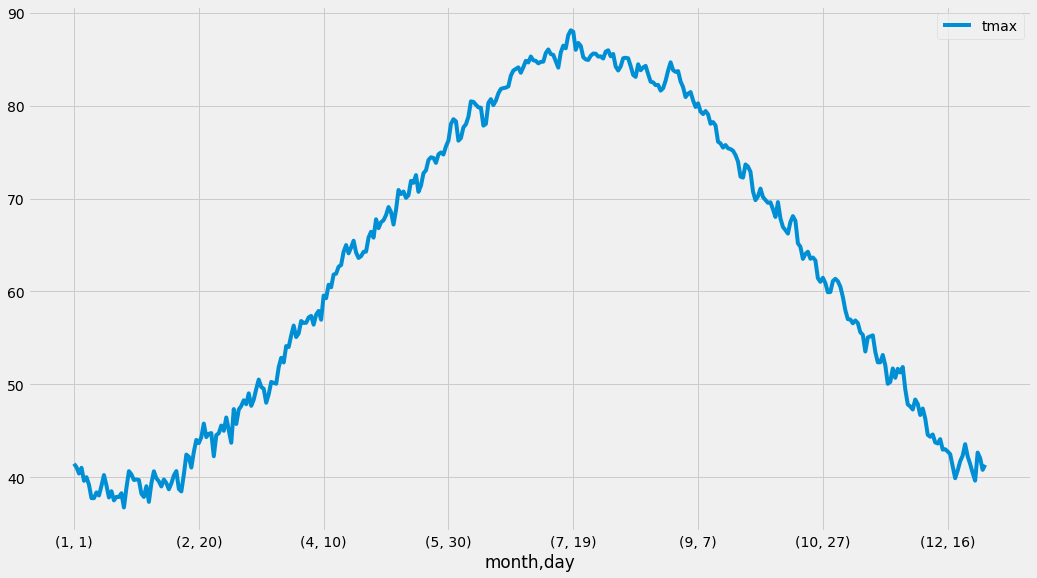

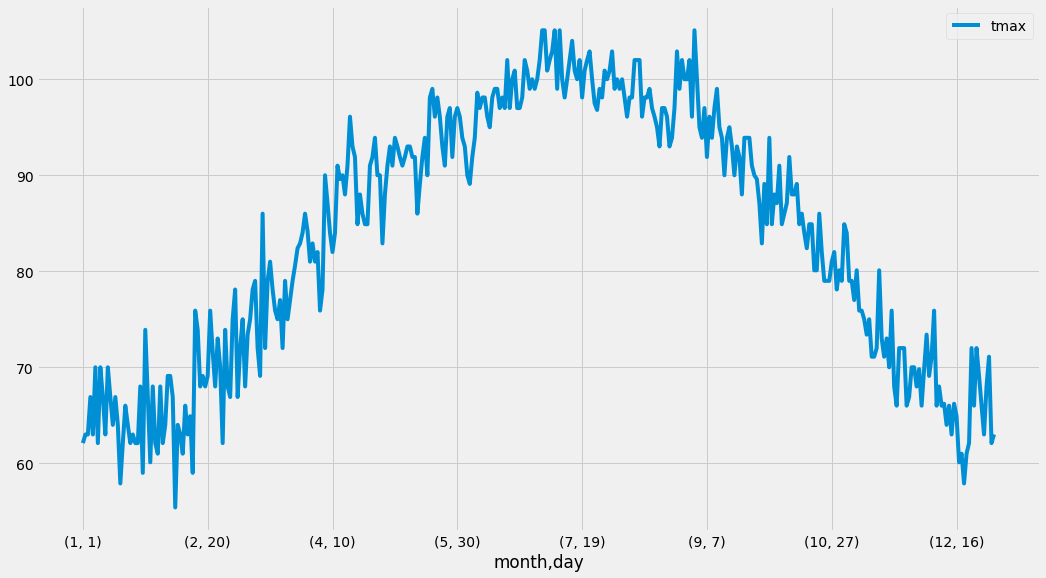

In [428]:
daily_max_avg.plot()
daily_max_max.plot()
plt.show()


In [429]:
# check if today hotter than average
today = end.strftime("%Y-%m-%d")
Month, Day, Year = end.month, end.day, end.year

todays_high = data.tmax.loc[today]
todays_avg_high = daily_max_avg.tmax.loc[(Month, Day)]
todays_max_high = daily_max_max.tmax.loc[(Month, Day)]

In [430]:
if todays_high > todays_avg_high:
    print(
        f"The high today in New York is {todays_high:.1f}°F, {todays_high - todays_avg_high:.1f}°F hotter than today's {N}-year average."
    )
else:
    print(
        f"The high today in New York is {todays_high:.1f}°F, {todays_high - todays_avg_high:.1f}°F cooler than today's {N}-year average."
    )
print(f"The {N}-year historical high for today is {todays_max_high:.1f}°F")


The high today in New York is 71.1°F, -5.4°F cooler than today's 75-year average.
The 75-year historical high for today is 89.1°F


In [431]:
# # scatter plot of today's temps
pd.options.mode.chained_assignment = None
daily_hist_series = data[(data["month"] == Month) & (data["day"] == Day)]
daily_hist_series["most_recent"] = np.where(
    daily_hist_series["year"] == daily_hist_series["year"].max(), 1, 0
)

In [448]:
# add N year spline fit, with confidence bars
x, y = daily_hist_series["year"].values.reshape(-1, 1), daily_hist_series[
    ["tmax"]
].values.reshape(-1)
model = make_pipeline(SplineTransformer(
    n_knots=4, degree=2), Ridge(alpha=1e-3))
model.fit(x, y)

y_true_long = np.linspace(y.min(), y.max(), 500)
x_plot = np.linspace(Year - N, Year, 500).reshape(-1, 1)
y_pred = model.predict(x).reshape(-1)
y_plot = model.predict(x_plot)


In [449]:
residuals = (y_true_long - y_plot).reshape(-1)
res_sd = np.std(residuals)
leverage = np.diagonal(x_plot.dot(np.linalg.inv(x_plot.T.dot(x_plot)).dot(x_plot.T)))
jackknife_se = residuals / (res_sd * np.sqrt(1 - leverage))

upper_jk_ci = y_plot + (1.96 * jackknife_se)
lower_jk_ci = y_plot - (1.96 * jackknife_se)

In [450]:
months = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split(" ")
calendar = {idx + 1: month for (idx, month) in enumerate(months)}

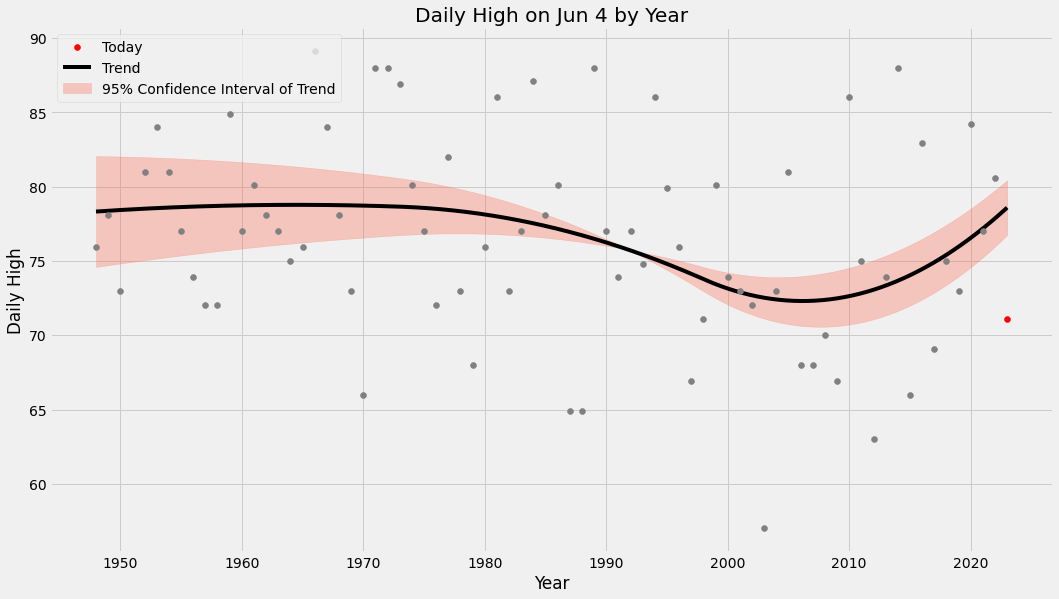

In [453]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (16, 9)

plt.scatter(
    daily_hist_series["year"][daily_hist_series["most_recent"] == 0],
    daily_hist_series["tmax"][daily_hist_series["most_recent"] == 0],
    color="gray",
    zorder=3,
)
plt.scatter(
    daily_hist_series["year"][daily_hist_series["most_recent"] == 1],
    daily_hist_series["tmax"][daily_hist_series["most_recent"] == 1],
    color="red",
    label="Today",
    zorder=4,
)

plt.plot(x_plot, y_plot, color="Black", zorder=2, label="Trend")

plt.fill_between(
    x_plot.reshape(-1),
    upper_jk_ci,
    lower_jk_ci,
    color="tomato",
    zorder=1,
    alpha=0.3,
    label="95% Confidence Interval of Trend",
)


plt.xlabel("Year")
plt.ylabel("Daily High")
plt.title(f"Daily High on {calendar[Month]} {Day} by Year")
plt.legend(loc="upper left")
plt.show()


In [452]:
# fit <- smooth.spline(data$x, data$y)      # smooth.spline fit
#   res <- (fit$yin - fit$y)/(1-fit$lev)      # jackknife residuals
# sigma <- sqrt(var(res))                     # estimate sd

# upper <- fit$y + 2.0*sigma*sqrt(fit$lev)   # upper 95% conf. band
# lower <- fit$y - 2.0*sigma*sqrt(fit$lev)   # lower 95% conf. band
# matplot(fit$x, cbind(upper, fit$y, lower), type="plp", pch=".")
